# 1.0 Environment setup, module import

In [1]:
# add toolbox to src (THIS WILL NOT BE REQUIRED ONCE DEPLOYED)
import sys
from pathlib import Path
src_path = Path("../../src").resolve()

if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from toolbox.steps.base_step import BaseStep, register_step
from toolbox.steps.custom import find_profiles_ALR as fpALR
import toolbox.utils.diagnostics as diag
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
import tkinter as tk
import numpy as np
import re
import io
import matplotlib.pyplot as plt

[Discovery] Scanning for step modules in C:\Users\hanshil\Documents\GitHub\toolbox\src\toolbox\steps\custom
[Discovery] Importing step module: toolbox.steps.custom.argo_qc
[Discovery] Importing step module: toolbox.steps.custom.calibration
[Discovery] Importing step module: toolbox.steps.custom.derive_ctd
[Discovery] Failed to import toolbox.steps.custom.derive_ctd: No module named 'gsw'
[Discovery] Importing step module: toolbox.steps.custom.export
[Discovery] Importing step module: toolbox.steps.custom.find_profiles
[Discovery] Importing step module: toolbox.steps.custom.find_profiles_ALR
[Discovery] Importing step module: toolbox.steps.custom.gen_data
[Discovery] Importing step module: toolbox.steps.custom.load_data
[Discovery] Failed to import toolbox.steps.custom.load_data: No module named 'gsw'
[Discovery] Importing step module: toolbox.steps.custom.variables.salinity
[Discovery] Failed to import toolbox.steps.custom.variables.salinity: No module named 'gsw'
[Discovery] Registere

# 2.0 Data import
Non-OG1 formatted ALR data is read in, formatted as a .log text file </br>
For compatability, looking to format into this input format: </br>
```
    Parameters
    ----------
    df : polars.DataFrame
        Input dataframe containing time and depth measurements
    gradient_thresholds : list
        Two-element list [positive_threshold, negative_threshold] defining the vertical velocity
        range (in meters/second) that is NOT considered part of a profile. typical values are around [0.02, -0.02]
    filter_win_sizes : list, default= ['20s', '10s']
        Window sizes for the compound filter applied to gradient calculations, in Polars duration format.
        index 0 controls the rolling median window size and index 1 controls the rolling mean window size.
    time_col : str, default='TIME'
        Name of the column containing timestamp data
    depth_col : str, default='DEPTH'
        Name of the column containing depth measurements
```

## 2.1 Data directories
Locations where the ALR data is stored, building lists of all relevant files

In [2]:
# Folder containing CTD files
sci_ctd_dir = Path("../../test_data/ALR_4")
sci_ctd_file_type = '*.log'

# Get a list of all .log files
sci_ctd_data_files = [str(file.resolve()) for file in sci_ctd_dir.glob(sci_ctd_file_type)]

# Folder containing science_navigation files
sci_nav_dir = Path("../../test_data/ALR_4")
sci_nav_file_type = '*.csv'

# Get a list of all .log files
sci_nav_data_files = [str(file.resolve()) for file in sci_nav_dir.glob(sci_nav_file_type)]


## 2.2 Loading in a single file set
Parse a "ctd" and a "nav" file, combine them into a single Polars dataframe named 'combined'.

In [3]:

# Read in the CTD data
sci_ctd_file = sci_ctd_data_files[1]
sci_nav_file = sci_nav_data_files[1]

# Read in the nav data

with open(sci_ctd_file, "r") as f:
    lines = f.readlines()

# Identify start/end of each segment
segments = []
current_type = None
current_start = None

for i, line in enumerate(lines):
    if "4 Hz" in line:
        if current_type is not None:
            segments.append((current_type, current_start, i))
        current_type = "4hz"
        current_start = i + 1
    elif "1 Hz" in line:
        if current_type is not None:
            segments.append((current_type, current_start, i))
        current_type = "1hz"
        current_start = i + 1

if current_type is not None:
    segments.append((current_type, current_start, len(lines)))

parsed_segments = []

for seg_type, start, end in segments:
    raw = "".join(lines[start:end])

    if seg_type == "4hz":
        df = pl.read_csv(
            io.StringIO(raw),
            has_header=False,
            separator=",",
            new_columns=["Timestamp", "Pressure"],
            schema_overrides={
                "Timestamp": pl.Float64,
                "Pressure": pl.Float64,
            },
            null_values=["", "NaN", "S>"],
            ignore_errors=True
        )

    elif seg_type == "1hz":
        df = pl.read_csv(
            io.StringIO(raw),
            has_header=False,
            separator=",",
            new_columns=["Timestamp", "Conductivity", "Temperature", "Pressure", "Oxygen"],
            schema_overrides={
                "Timestamp": pl.Float64,
                "Conductivity": pl.Float64,
                "Temperature": pl.Float64,
                "Pressure": pl.Float64,
                "Oxygen": pl.Float64,
            },
            null_values=["", "NaN", "S>"],
            ignore_errors=True
        )

    parsed_segments.append(df)

# Combine all segments
all_data = pl.concat(parsed_segments, how="diagonal").sort("Timestamp")

# Read the nav data
sci_nav_data = pl.read_csv(
              sci_nav_file,
              schema_overrides={
             "timestamp": pl.Float64,
             "position_lat": pl.Float64,
             "position_lon": pl.Float64,
             "depth": pl.Float64,
             "roll": pl.Float64,
             "pitch": pl.Float64,
             "heading": pl.Float64,
             "altitude": pl.Float64}
)

# Merge two datasets
all_data = all_data.with_columns(pl.col("Timestamp").cast(pl.Float64))
sci_nav_data = sci_nav_data.rename({"timestamp": "Timestamp"}).with_columns(
    pl.col("Timestamp").cast(pl.Float64)
)

combined = all_data.join(
    sci_nav_data,
    on="Timestamp",
    how="full"   # union of both datasets
)

# Collapse Timestamp + Timestamp_right into a single column
if "Timestamp_right" in combined.columns:
    combined = combined.with_columns(
        pl.coalesce([pl.col("Timestamp"), pl.col("Timestamp_right")]).alias("Timestamp")
    ).drop("Timestamp_right")

# Sort chronologically
combined = combined.sort("Timestamp")

# Interpolate depth/pressure values over time gaps
combined = combined.with_columns(
    pl.col("Pressure").interpolate_by("Timestamp")
)


## 2.3 All files
Parse all files listed from section 2.1 into a single Polars dataframe labelled 'combined'.

In [4]:
# --- Collect all CTD data ---
ctd_runs = []

for sci_ctd_file in sci_ctd_data_files:
    with open(sci_ctd_file, "r") as f:
        lines = f.readlines()

    # Identify start/end of each segment
    segments = []
    current_type = None
    current_start = None
    for i, line in enumerate(lines):
        if "4 Hz" in line:
            if current_type is not None:
                segments.append((current_type, current_start, i))
            current_type = "4hz"
            current_start = i + 1
        elif "1 Hz" in line:
            if current_type is not None:
                segments.append((current_type, current_start, i))
            current_type = "1hz"
            current_start = i + 1
    if current_type is not None:
        segments.append((current_type, current_start, len(lines)))

    parsed_segments = []
    for seg_type, start, end in segments:
        raw = "".join(lines[start:end])
        if seg_type == "4hz":
            df = pl.read_csv(
                io.StringIO(raw),
                has_header=False,
                separator=",",
                new_columns=["Timestamp", "Pressure"],
                schema_overrides={"Timestamp": pl.Float64, "Pressure": pl.Float64},
                null_values=["", "NaN", "S>"],
                ignore_errors=True
            )
        elif seg_type == "1hz":
            df = pl.read_csv(
                io.StringIO(raw),
                has_header=False,
                separator=",",
                new_columns=["Timestamp", "Conductivity", "Temperature", "Pressure", "Oxygen"],
                schema_overrides={
                    "Timestamp": pl.Float64,
                    "Conductivity": pl.Float64,
                    "Temperature": pl.Float64,
                    "Pressure": pl.Float64,
                    "Oxygen": pl.Float64,
                },
                null_values=["", "NaN", "S>"],
                ignore_errors=True
            )
        parsed_segments.append(df)

    run_df = pl.concat(parsed_segments, how="diagonal").sort("Timestamp")
    run_df = run_df.with_columns(pl.lit(sci_ctd_file).alias("source_ctd"))
    ctd_runs.append(run_df)

all_ctd = pl.concat(ctd_runs, how="diagonal").sort("Timestamp")

# --- Collect all NAV data ---
nav_runs = []
for sci_nav_file in sci_nav_data_files:
    df = pl.read_csv(
        sci_nav_file,
        schema_overrides={
            "timestamp": pl.Float64,
            "position_lat": pl.Float64,
            "position_lon": pl.Float64,
            "depth": pl.Float64,
            "roll": pl.Float64,
            "pitch": pl.Float64,
            "heading": pl.Float64,
            "altitude": pl.Float64
        }
    )
    df = df.rename({"timestamp": "Timestamp"})
    df = df.with_columns(
        pl.col("Timestamp").cast(pl.Float64),
        pl.lit(sci_nav_file).alias("source_nav")
    )
    nav_runs.append(df)

all_nav = pl.concat(nav_runs, how="diagonal").sort("Timestamp")

# --- Merge CTD + NAV across all files ---
big_df = all_ctd.join(all_nav, on="Timestamp", how="full")

# Collapse Timestamp_right if it appears
if "Timestamp_right" in big_df.columns:
    big_df = big_df.with_columns(
        pl.coalesce([pl.col("Timestamp"), pl.col("Timestamp_right")]).alias("Timestamp")
    ).drop("Timestamp_right")

# Sort chronologically
big_df = big_df.sort("Timestamp")

# Interpolate Pressure if possible
if big_df["Pressure"].drop_nulls().len() > 0:
    big_df = big_df.with_columns(
        pl.col("Pressure").interpolate_by("Timestamp")
    )

# QC: drop rows where BOTH Pressure and pitch are null
big_df = big_df.filter(
    ~(pl.col("Pressure").is_null() & pl.col("pitch").is_null())
)

# Add an index column to big_df for tracking
big_df = big_df.with_row_index(name="row_id")

## 2.4 Inspecting the data

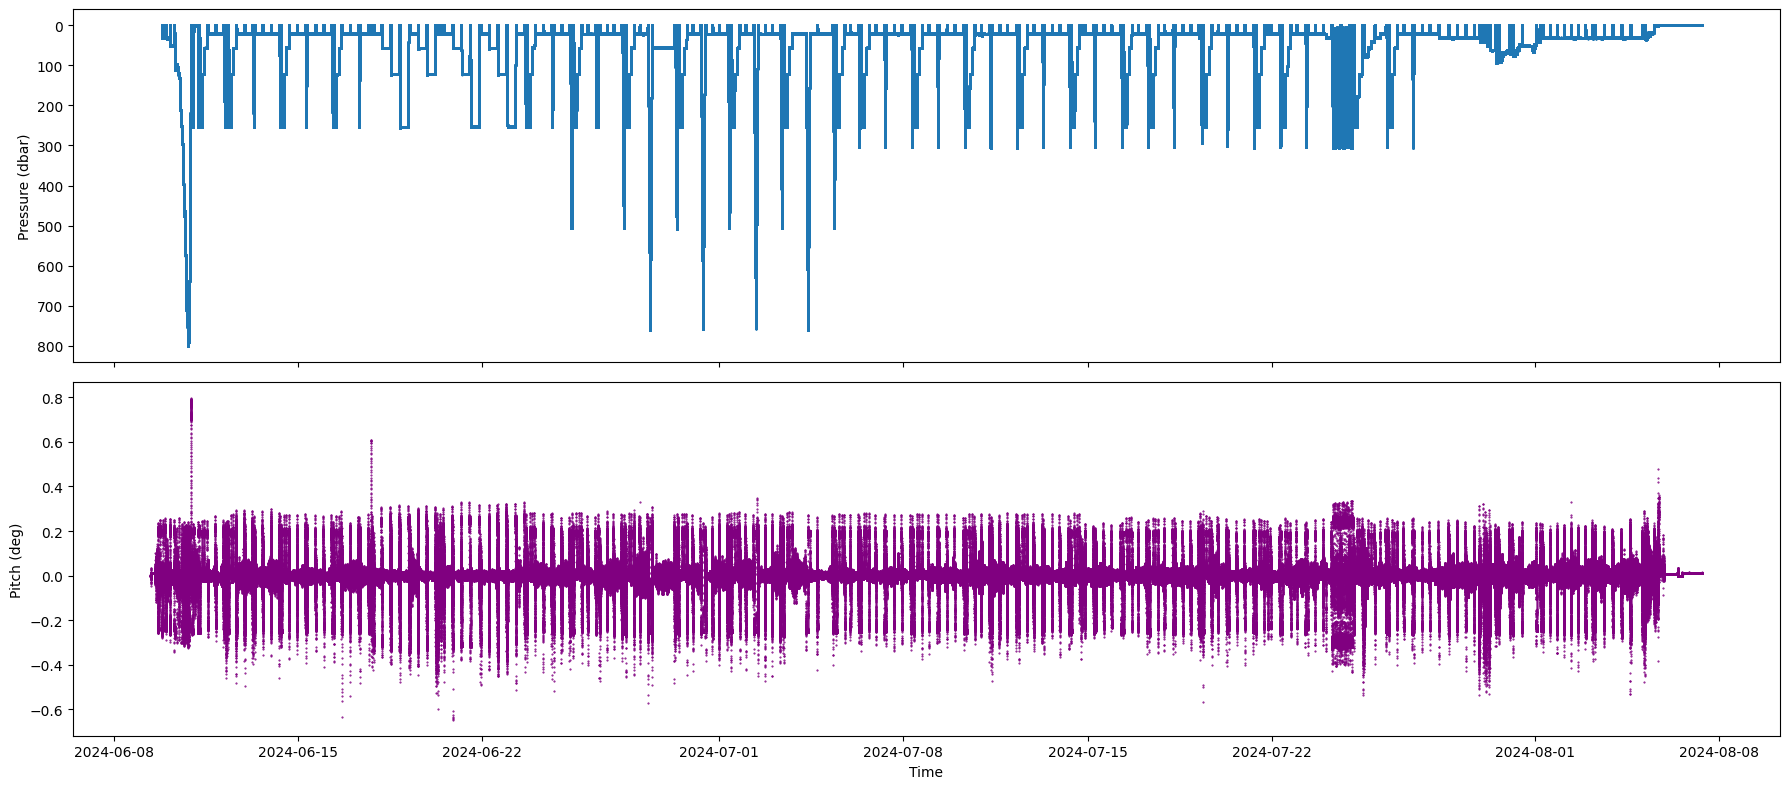

In [5]:
# Convert TIME column
df_plot = big_df.with_columns(
    (pl.col("Timestamp") * 1e9).cast(pl.Datetime("ns")).alias("TIME")
)

# Extract numpy arrays
time_vals = df_plot["TIME"].to_numpy()
pressure_vals = df_plot["Pressure"].to_numpy()
pitch_vals = df_plot["pitch"].to_numpy()

# Plotting (2 panels, shared x-axis)
fig, axs = plt.subplots(2, 1, figsize=(18, 8), sharex=True)

# Pressure (treat as depth)
axs[0].plot(time_vals, pressure_vals,
            marker=".", markersize=1, ls="", c="tab:blue")
axs[0].set(ylabel="Pressure (dbar)")
axs[0].invert_yaxis()

# Pitch
axs[1].plot(time_vals, pitch_vals,
            marker=".", markersize=1, ls="", c="purple")
axs[1].set(xlabel="Time", ylabel="Pitch (deg)")

plt.tight_layout()
plt.show()


# 3.0 Profile analysis
Using the output of either section 2.2 or 2.3 for profile analysis using the 'find_profiles_ALR.py' script and it's contained functions.

## 3.1 Running 'find_profiles_ALR.py' 
Take above ALR data and output into a profiled format

In [6]:
# --- Profiling analysis ---

import importlib
import toolbox.steps.custom.find_profiles_ALR as fpALR
importlib.reload(fpALR)

gradient_thresholds = [0.05, -0.05]
cust_gradient_thresholds = [0.005, -0.025]
custom_column = 'pitch'

df_to_use = big_df

# Rename columns to what find_profiles expects
df = df_to_use.rename({
    "Timestamp": "TIME",
    "Pressure": "DEPTH"   # treat pressure as depth for profiling
})

# Convert TIME (epoch seconds float) → Datetime[ns]
df = df.with_columns(
    (pl.col("TIME") * 1e9).cast(pl.Datetime("ns")).alias("TIME")
)

# Run profile detection with a custom column
profiles_df = fpALR.find_profiles(
    df,
    gradient_thresholds=gradient_thresholds,
    filter_win_sizes=["30s", "20s"],
    time_col="TIME",
    depth_col="DEPTH",
    cust_col=custom_column,
    cust_gradient_thresholds=cust_gradient_thresholds,
    transect_duration='5m',
    transect_depth_range=[10,20,30],
    transect_depth_bottom_limits=[20,50],
    profile_duration='2m',
    strict_profiles=False,
    use_only_pit_vel=False,
    back_fill_mod=1,
    backfill_segments=True,
)

profiles_df = profiles_df.drop_nans('is_profile')


In [7]:
# Split profiles vs not profiles
profiles = profiles_df.drop_nans().filter(pl.col("is_profile").cast(pl.Boolean))
not_profiles = profiles_df.drop_nans().filter(pl.col("is_profile").cast(pl.Boolean).not_())
transects = profiles_df.drop_nans().filter(pl.col("is_transect").cast(pl.Boolean))
not_transects = profiles_df.drop_nans().filter(pl.col("is_transect").cast(pl.Boolean).not_())

# === Plotting ===
import matplotlib as mpl
mpl.use('tkagg')
fig, axs = plt.subplots(5, 1, figsize=(18, 10), height_ratios=[3, 3, 1, 3, 3], sharex=True)

axs[0].set(xlabel="Time", ylabel="Interpolated Depth")
axs[1].set(xlabel="Time", ylabel="Vertical Velocity")
axs[2].set(xlabel="Time", ylabel="Profile Number")
axs[3].set(xlabel="Time", ylabel=custom_column)   # <<< custom col
axs[4].set(xlabel="Time", ylabel=custom_column)   # <<< custom col

# Profile vs not profile (depth + velocity)
for data, col, label in zip([profiles, not_profiles, transects], 
                            ["tab:blue", "tab:red", "tab:orange"], 
                            ["Profile", "Not Profile", "Transect"]):
    axs[0].plot(data["TIME"].to_numpy(), -data["INTERP_DEPTH"].to_numpy(),
                marker=".", markersize=1, ls="", c=col, label=label)
    axs[1].plot(data["TIME"].to_numpy(), data["smooth_grad"].to_numpy(),
                marker=".", markersize=1, ls="", c=col, label=label)

# Raw gradients + thresholds
axs[1].plot(profiles_df["TIME"].to_numpy(), profiles_df["grad"].to_numpy(),
            c="k", alpha=0.1, label="Raw Velocity")
for val, label in zip(gradient_thresholds, ["Gradient Thresholds", None]):
    axs[1].axhline(val, ls="--", color="gray", label=label)

# Profile numbers
axs[2].plot(profiles_df["TIME"].to_numpy(), profiles_df["profile_num"].to_numpy(), c="gray")
axs[2].plot(profiles_df["TIME"].to_numpy(), profiles_df["profile_num_new"].to_numpy(), c="red")

# Custom column (pitch)
if custom_column in profiles_df.columns:
    axs[3].plot(profiles_df["TIME"].to_numpy(),
                profiles_df[custom_column].to_numpy(),
                c="purple", marker=".", markersize=1, ls="", label=custom_column)
    axs[3].legend(loc="upper right")

# Custom column (pitch)
if custom_column in profiles_df.columns:
    axs[4].plot(profiles_df["TIME"].to_numpy(),
                -profiles_df['smooth_INTERP_pitch'].to_numpy()*profiles_df['smooth_grad'].to_numpy(),
                c="purple", marker=".", markersize=1, ls="", label=custom_column)
    axs[4].legend(loc="upper right")
    axs[4].set_ylim([0, 0.05])
for val, label in zip(cust_gradient_thresholds, ["Gradient Thresholds", None]):
    axs[4].axhline(val, ls="--", color="gray", label=label)

for ax in axs[:2]:
    ax.legend(loc="upper right")

plt.tight_layout()
plt.show(block=True)


# 4.0 Export to netCDF

In [9]:
plt.close()

In [10]:
# Ensure both sides have matching TIME column format
df = df.with_columns(pl.col("TIME").cast(pl.Datetime("ns")))
profile_annotations = profiles_df.with_columns(pl.col("TIME").cast(pl.Datetime("ns")))

big_df_with_profiles = df.join(
    profile_annotations,
    on=["TIME", "DEPTH"],
    how="left"
)

big_df_with_profiles = big_df_with_profiles.filter(
    pl.col("TIME").is_not_null()
)


In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import polars as pl

mpl.use("tkagg")

# === Helper: Truncate colormap ===
def truncate_cmap(name, minval=0.25, maxval=1.0, n=256):
    cmap = mpl.colormaps[name]
    return mpl.colors.LinearSegmentedColormap.from_list(
        f"trunc({name},{minval},{maxval})", cmap(np.linspace(minval, maxval, n))
    )

def to_pytime(series: pl.Series):
    """Convert Polars datetime column to numpy array of Python datetimes."""
    return np.array(series.to_list())

# === Extract data ===
time_vals = to_pytime(big_df_with_profiles["TIME"])
pressure_vals = big_df_with_profiles["DEPTH"].to_numpy()
pitch_vals = big_df_with_profiles["pitch"].to_numpy()
profile_nums = big_df_with_profiles["profile_num"].to_numpy()
transect_nums = big_df_with_profiles["transect_num"].to_numpy()
profile_nums_new = big_df_with_profiles["profile_num_new"].to_numpy()

# === Figure setup ===
fig, axs = plt.subplots(
    3, 1, figsize=(18, 12),
    height_ratios=[3, 3, 3],
    sharex=True
)

# === Profile plots ===
unique_profiles = np.unique(profile_nums[profile_nums >= 0])
unique_profiles_new = np.unique(profile_nums_new[profile_nums_new >= 0])

cmap_orig = truncate_cmap("Blues")
norm_orig = Normalize(vmin=unique_profiles.min(), vmax=unique_profiles.max())
cmap_new = truncate_cmap("Reds")
norm_new = Normalize(vmin=unique_profiles_new.min(), vmax=unique_profiles_new.max())

# Original profiles (blue)
for pid in unique_profiles:
    mask = profile_nums == pid
    axs[0].plot(time_vals[mask], pressure_vals[mask],
                color=cmap_orig(norm_orig(pid)), lw=2, alpha=0.9)

# Filtered profiles (red)
for pid in unique_profiles_new:
    mask = profile_nums_new == pid
    axs[0].plot(time_vals[mask], pressure_vals[mask],
                color=cmap_new(norm_new(pid)), lw=1.5, alpha=0.9)

axs[0].invert_yaxis()
axs[0].set(ylabel="Pressure (dbar)", title="Profiles (Original vs Filtered)")

# Colorbars (inset)
cax1 = inset_axes(axs[0], width="35%", height="4%", loc="lower left", borderpad=2)
fig.colorbar(ScalarMappable(norm=norm_orig, cmap=cmap_orig),
             cax=cax1, orientation="horizontal", label="Original profile #")
cax2 = inset_axes(axs[0], width="35%", height="4%", loc="lower right", borderpad=2)
fig.colorbar(ScalarMappable(norm=norm_new, cmap=cmap_new),
             cax=cax2, orientation="horizontal", label="Filtered profile #")

# === Raw pressure ===
axs[1].plot(time_vals, pressure_vals, ".", markersize=1, c="tab:blue")
axs[1].invert_yaxis()
axs[1].set(ylabel="Pressure (dbar)")

# === Transects ===
unique_transects = np.unique(transect_nums[transect_nums >= 0])
cmap_transects = truncate_cmap("Greens")
norm_transects = Normalize(vmin=unique_transects.min(), vmax=unique_transects.max())

for tid in unique_transects:
    mask = transect_nums == tid
    axs[2].plot(time_vals[mask], pressure_vals[mask],
                color=cmap_transects(norm_transects(tid)), lw=1)

axs[2].invert_yaxis()
axs[2].set(ylabel="Pressure (dbar)", title="Transects")

# Colorbar inset
cax_tr = inset_axes(axs[2], width="50%", height="4%", loc="lower center", borderpad=1.5)
fig.colorbar(ScalarMappable(norm=norm_transects, cmap=cmap_transects),
             cax=cax_tr, orientation="horizontal", label="Transect number")


fig.tight_layout()
plt.show(block=True)


C:\Users\hanshil\AppData\Local\Temp\ipykernel_17636\575261458.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Good evening GPT, hope you're doing well!

I'd like to convert a dataframe in Python into a series of distinctly labelled netCDF files.

I have the following polars dataframe:

big_df_with_profiles

With the following characteristics:

big_df_with_profiles.head(10)


<div><style>
.dataframe > thead > tr,
.dataframe > tbody > tr {
  text-align: right;
  white-space: pre-wrap;
}
</style>
<small>shape: (10, 37)</small><table border="1" class="dataframe"><thead><tr><th>row_id</th><th>TIME</th><th>DEPTH</th><th>Conductivity</th><th>Temperature</th><th>Oxygen</th><th>source_ctd</th><th>position_lat</th><th>position_lon</th><th>depth</th><th>roll</th><th>pitch</th><th>heading</th><th>altitude</th><th>source_nav</th><th>pitch_right</th><th>INTERP_DEPTH</th><th>INTERP_pitch</th><th>dt</th><th>dz</th><th>dC</th><th>grad</th><th>dC/dt</th><th>smooth_grad</th><th>smooth_INTERP_pitch</th><th>smooth_dC/dt</th><th>grad_profile</th><th>pitch_profile</th><th>is_profile</th><th>profile_num</th><th>profile_num_new</th><th>roll_min_depth</th><th>roll_max_depth</th><th>depth_stable</th><th>pitch_flat</th><th>is_transect</th><th>transect_num</th></tr><tr><td>u32</td><td>datetime[ns]</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td><td>str</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td><td>str</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td><td>f64</td></tr></thead><tbody><tr><td>0</td><td>2024-06-09 09:29:31.578629888</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>63.443264</td><td>-20.26803</td><td>0.155416</td><td>0.0</td><td>0.0</td><td>0.0</td><td>184.259995</td><td>&quot;C:\Users\hanshil\Documents\Git…</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td></tr><tr><td>1</td><td>2024-06-09 09:29:31.617340160</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>63.443264</td><td>-20.26803</td><td>0.155416</td><td>0.0</td><td>0.0</td><td>0.0</td><td>193.979996</td><td>&quot;C:\Users\hanshil\Documents\Git…</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td></tr><tr><td>2</td><td>2024-06-09 09:29:32.668800</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>63.443264</td><td>-20.26803</td><td>0.143438</td><td>0.0</td><td>0.0</td><td>0.0</td><td>193.979996</td><td>&quot;C:\Users\hanshil\Documents\Git…</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td></tr><tr><td>3</td><td>2024-06-09 09:29:33.734360064</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>63.443264</td><td>-20.26803</td><td>0.146394</td><td>0.0</td><td>0.0</td><td>0.0</td><td>193.979996</td><td>&quot;C:\Users\hanshil\Documents\Git…</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td></tr><tr><td>4</td><td>2024-06-09 09:29:34.640339968</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>63.443264</td><td>-20.26803</td><td>0.152938</td><td>0.0</td><td>0.0</td><td>0.0</td><td>188.335007</td><td>&quot;C:\Users\hanshil\Documents\Git…</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td></tr><tr><td>5</td><td>2024-06-09 09:29:35.654840064</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>63.443264</td><td>-20.26803</td><td>0.151805</td><td>0.0</td><td>0.0</td><td>0.0</td><td>192.350006</td><td>&quot;C:\Users\hanshil\Documents\Git…</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td></tr><tr><td>6</td><td>2024-06-09 09:29:36.628560128</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>63.443264</td><td>-20.26803</td><td>0.142937</td><td>-0.015278</td><td>0.00218</td><td>0.745214</td><td>192.350006</td><td>&quot;C:\Users\hanshil\Documents\Git…</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td></tr><tr><td>7</td><td>2024-06-09 09:29:37.624020224</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>63.443264</td><td>-20.26803</td><td>0.135844</td><td>-0.015348</td><td>0.002386</td><td>0.745505</td><td>189.604996</td><td>&quot;C:\Users\hanshil\Documents\Git…</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td></tr><tr><td>8</td><td>2024-06-09 09:29:38.636819968</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>63.443264</td><td>-20.26803</td><td>0.136139</td><td>-0.015052</td><td>0.0023</td><td>0.744832</td><td>189.604996</td><td>&quot;C:\Users\hanshil\Documents\Git…</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td></tr><tr><td>9</td><td>2024-06-09 09:29:39.611560192</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>63.443264</td><td>-20.26803</td><td>0.13936</td><td>-0.015037</td><td>0.002175</td><td>0.746551</td><td>192.714996</td><td>&quot;C:\Users\hanshil\Documents\Git…</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td><td>null</td></tr></tbody></table></div>

big_df_with_profiles.shape
(10656537, 37)

I don't need to bring across the 'source_ctd' elements. I'd like to pick which columns we bring across eventually, but for now we just need to ensure each netCDF contains:
Depth
Id like the netCDF to be structured such that we have a netCDF file for each unique profile ID and each unique transect ID.

I'd like to iterate through the files with the following naming convention logic, with a base of:

ALRXXX_XXXX_XXXX_XXXX_aXXXX

Where the first portion:

Is the serial number of the ALR (this should be user defined and fixed for a given export 'chunk' of files)
e.g. ALR004

The second:

Is the 'unique_ID' of the file. This should increase by 1 for each new file.
e.g. 0001

The third:
This is the 'segment_ID'. Segments are periods of time between two subsequent dives (in this case the first point defining a downcast, with downcast defined as a profile of increasing depth) from the surface (here defined as anything <5m depth). 
e.g. 0001

The fourth:
event_type_ID and unique_event_type_ID. A letter and number corresponding to a specific type of profile, whether it is a downcast (depth values increase), an upcast (depth values decrease), a transect (already labelled in our files), or a transect at the surface (depth values for the transect are on average shallower than 5m, this 5m threshold should be user defined).
e.g. s0001

So a complete file for the first, surface transect of a deployment (a deployment being this large dataframe), would be:
ALR004_0001_0001_s0001

The eighty-second sample from the same deployment (dataframe), a downcast in the twenty-ninth segment (peroids between two dowcasts from the surface), which is the twentieth downcast, would be:
ALR004_0082_0029_d0020







In [14]:
# -*- coding: utf-8 -*-
"""
Export ALR profiles, transects, and 'other' (x) sections from a Polars DataFrame to NetCDF files.

Changes vs. previous version:
- Filenames now include YYYYMMDD (UTC) of the event's first datapoint:  ALR004_20240401_0082_0029_d0020.nc
- All data are exported: in addition to profiles (d/u) and transects (t/s), we create one 'x' event per segment
  for rows that are neither profile nor transect. Segment '0000' is everything prior to the first surface-origin
  downcast; subsequent segments increment at each such downcast start.

Requirements:
    pip install polars xarray netCDF4 numpy pandas
"""

# -*- coding: utf-8 -*-
from __future__ import annotations
import os
from typing import Optional, List, Dict, Tuple
import numpy as np
import pandas as pd
import polars as pl
import xarray as xr
from bisect import bisect_right


def _ensure_dir(path: str) -> None:
    os.makedirs(path, exist_ok=True)


def _first_last_depth_for_profile(g: pl.DataFrame) -> Tuple[Optional[float], Optional[float]]:
    g_sorted = g.sort("TIME")
    if "DEPTH" in g.columns:
        d = g_sorted.get_column("DEPTH").drop_nulls()
        if d.len() > 0:
            return float(d[0]), float(d[-1])
    if "depth" in g.columns:
        d = g_sorted.get_column("depth").drop_nulls()
        if d.len() > 0:
            return float(d[0]), float(d[-1])
    return None, None


def _mean_depth(g: pl.DataFrame) -> Optional[float]:
    if "DEPTH" in g.columns:
        m = g.select(pl.col("DEPTH")).mean().item()
        if m is not None:
            return float(m)
    if "depth" in g.columns:
        m = g.select(pl.col("depth")).mean().item()
        if m is not None:
            return float(m)
    return None


def _event_type_for_profile(g: pl.DataFrame) -> str:
    first_d, last_d = _first_last_depth_for_profile(g)
    if first_d is None or last_d is None:
        return "d"
    if first_d < last_d:
        return "d"
    elif first_d > last_d:
        return "u"
    else:
        return "d"


def _event_type_for_transect(g: pl.DataFrame, surface_thresh: float) -> str:
    m = _mean_depth(g)
    if m is None:
        return "t"
    return "s" if m < surface_thresh else "t"


def _dataset_from_group(g: pl.DataFrame) -> xr.Dataset:
    rename_map = {
        "DEPTH": "DEPTH_SCI",
        "depth": "DEPTH_ENG",
        "INTERP_DEPTH": "DEPTH_SCI_INTERP",
        "position_lat": "LAT",
        "position_lon": "LON",
        "TIME": "TIME",
    }
    keep_cols = [c for c in rename_map.keys() if c in g.columns]
    if "TIME" not in keep_cols:
        raise ValueError("Required column 'TIME' missing from group.")

    g2 = (
        g.sort("TIME")
         .select(keep_cols)
         .rename({k: v for k, v in rename_map.items() if k in keep_cols})
    )

    pdf = g2.to_pandas()
    pdf["TIME"] = pd.to_datetime(pdf["TIME"], utc=True, errors="coerce")
    pdf = pdf.dropna(subset=["TIME"])

    epoch = np.datetime64("1970-01-01T00:00:00")
    time_seconds = (pdf["TIME"].values.astype("datetime64[ns]") - epoch) / np.timedelta64(1, "s")

    ds = xr.Dataset(
        data_vars={
            k: (("TIME",), pdf[k].to_numpy())
            for k in ["DEPTH_SCI", "DEPTH_ENG", "DEPTH_SCI_INTERP", "LAT", "LON"]
            if k in pdf.columns
        },
        coords={"TIME": time_seconds},
    )

    ds["TIME"].attrs.update({
        "units": "seconds since 1970-01-01 00:00:00 UTC",
        "long_name": "time",
        "standard_name": "time",
    })

    ds.attrs.update({
        "Conventions": "CF-1.9",
        "title": "ALR profile/transect/other export",
        "institution": "Your Lab",
        "source": "Polars→xarray export",
        "history": "Created by export_alr_netcdf()",
    })
    return ds


def export_alr_netcdf(
    df: pl.DataFrame,
    *,
    alr_serial: str = "ALR004",
    surface_thresh: float = 5.0,
    output_dir: str = "output_ALR_netCDF",
    max_files: Optional[int] = 5,
) -> List[str]:
    """
    Exports per-profile (d/u), per-transect (t/s), and per-'other' contiguous run (x) NetCDF files.

    Filename:
        {alr_serial}_{YYYYMMDD}_{unique_id:04d}_{segment_id:04d}_{etype}{etype_idx:04d}.nc

    Segment ID:
        0000 for anything before the first downcast that begins shallower than `surface_thresh`.
        Increments by 1 at each such downcast start thereafter.
    """
    _ensure_dir(output_dir)

    must_have = ["TIME", "position_lat", "position_lon"]
    missing_req = [c for c in must_have if c not in df.columns]
    if missing_req:
        raise ValueError(f"Missing required columns: {missing_req}")

    maybe_cols = [
        "DEPTH", "depth", "INTERP_DEPTH",
        "profile_num_new", "transect_num",
        "is_profile", "is_transect",
    ]
    subset_cols = list(dict.fromkeys(must_have + [c for c in maybe_cols if c in df.columns]))

    # Sort and index early so we can split 'x' by contiguous runs.
    sdf = (
        df.select(subset_cols)
          .with_columns(pl.col("TIME").cast(pl.Datetime).alias("TIME"))
          .sort("TIME")
          .with_row_count("orig_idx")
    )

    # ---------- Build profile groups & collect downcast starts ----------
    profile_groups = []
    downcast_start_times_utc: List[pd.Timestamp] = []

    if "is_profile" in sdf.columns and "profile_num_new" in sdf.columns:
        prof_df = sdf.filter(pl.col("is_profile") == 1).drop_nulls(["profile_num_new"])
        if prof_df.height > 0:
            for key, g in prof_df.group_by("profile_num_new", maintain_order=False):
                start_time = pd.to_datetime(g.select(pl.col("TIME").min()).item(), utc=True)
                etype = _event_type_for_profile(g)
                profile_groups.append({
                    "kind": "profile",
                    "key": int(key[0]) if isinstance(key, tuple) else int(key),
                    "start_time": start_time,
                    "etype": etype,
                    "group": g.drop("orig_idx"),
                })
                if etype == "d":
                    first_d, _ = _first_last_depth_for_profile(g)
                    if first_d is not None and first_d < surface_thresh:
                        downcast_start_times_utc.append(start_time)

    # Keep these sorted for bisect-based segment lookup
    downcast_start_times_utc.sort()

    # ---------- Build transect groups ----------
    transect_groups = []
    if "is_transect" in sdf.columns and "transect_num" in sdf.columns:
        tran_df = sdf.filter(pl.col("is_transect") == 1).drop_nulls(["transect_num"])
        if tran_df.height > 0:
            for key, g in tran_df.group_by("transect_num", maintain_order=False):
                start_time = pd.to_datetime(g.select(pl.col("TIME").min()).item(), utc=True)
                etype = _event_type_for_transect(g, surface_thresh=surface_thresh)
                transect_groups.append({
                    "kind": "transect",
                    "key": int(key[0]) if isinstance(key, tuple) else int(key),
                    "start_time": start_time,
                    "etype": etype,
                    "group": g.drop("orig_idx"),
                })

    # ---------- Compute per-row segment_id (join_asof on downcast starts) ----------
    if downcast_start_times_utc:
        # Make naive-UTC datetimes for Polars join
        seg_starts = [pd.Timestamp(t).tz_convert("UTC").tz_localize(None).to_pydatetime()
                      for t in downcast_start_times_utc]
        seg_df = pl.DataFrame({"SEG_START": seg_starts}).with_row_count("segment_id", offset=1)
        sdf_with_seg = sdf.join_asof(
            seg_df.sort("SEG_START"),
            left_on="TIME", right_on="SEG_START",
            strategy="backward"
        ).with_columns(pl.col("segment_id").fill_null(0))
    else:
        sdf_with_seg = sdf.with_columns(pl.lit(0).alias("segment_id"))

    # ---------- Build 'x' groups: contiguous runs within each segment ----------
    # Rows that are neither profile nor transect
    not_flagged = (
        (pl.col("is_profile") != 1) & (pl.col("is_transect") != 1)
        if "is_profile" in sdf_with_seg.columns and "is_transect" in sdf_with_seg.columns
        else pl.lit(True)
    )

    other_df = (
        sdf_with_seg
        .filter(not_flagged)
        .select(["TIME", "position_lat", "position_lon", "DEPTH", "depth",
                 "INTERP_DEPTH", "segment_id", "orig_idx"])
        .sort(["segment_id", "orig_idx"])
        .with_columns([
            # new run when segment changes OR original index is not consecutive
            (
                (pl.col("segment_id").diff().fill_null(0) != 0)
                | (pl.col("orig_idx").diff() != 1)
            ).fill_null(True).cast(pl.Int8).alias("new_run")
        ])
        .with_columns([
            pl.col("new_run").cum_sum().alias("x_run_id")
        ])
    )

    x_groups = []
    if other_df.height > 0:
        for (seg_id, run_id), g in other_df.group_by(["segment_id", "x_run_id"], maintain_order=True):
            start_time = pd.to_datetime(g.select(pl.col("TIME").min()).item(), utc=True)
            x_groups.append({
                "kind": "other",
                "key": (int(seg_id), int(run_id)),
                "start_time": start_time,
                "etype": "x",
                "group": g.drop(["segment_id", "orig_idx", "new_run", "x_run_id"]),
                "segment_id_override": int(seg_id),
            })

    # ---------- Merge & sort all events ----------
    events = profile_groups + transect_groups + x_groups
    if not events:
        return []

    events.sort(key=lambda e: e["start_time"])

    # ---------- Write files ----------
    unique_id = 0
    per_type_counts: Dict[str, int] = {"d": 0, "u": 0, "t": 0, "s": 0, "x": 0}
    written: List[str] = []

    for ev in events:
        if max_files is not None and len(written) >= max_files:
            break

        etype = ev["etype"]

        # Segment ID lookup: count how many downcast starts <= this event's start_time
        seg_id_for_file = ev.get(
            "segment_id_override",
            bisect_right(downcast_start_times_utc, ev["start_time"])
        )

        per_type_counts[etype] += 1
        unique_id += 1

        ds = _dataset_from_group(ev["group"])

        date_str = ev["start_time"].strftime("%Y%m%d")
        fname = f"{alr_serial}_{date_str}_{unique_id:04d}_{seg_id_for_file:04d}_{etype}{per_type_counts[etype]:04d}.nc"
        fpath = os.path.join(output_dir, fname)

        ds.attrs.update({
            "alr_serial": alr_serial,
            "unique_id": unique_id,
            "segment_id": seg_id_for_file,
            "event_type": etype,         # d/u/t/s/x
            "group_kind": ev["kind"],    # profile/transect/other
            "group_key": ev["key"],
            "surface_threshold_m": surface_thresh,
            "event_start_utc": ev["start_time"].isoformat(),
        })

        ds.to_netcdf(fpath, engine="netcdf4", format="NETCDF4")
        written.append(fpath)

    return written

# -----------------------------

files = export_alr_netcdf(
    big_df_with_profiles,
    alr_serial="ALR004",
    surface_thresh=5.0,
    output_dir="output_ALR_netCDF",
    max_files=None,   # set to None to export all
)
print("\n".join(files))


C:\Users\hanshil\AppData\Local\Temp\ipykernel_660\2548720922.py:162: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  .with_row_count("orig_idx")
C:\Users\hanshil\AppData\Local\Temp\ipykernel_660\2548720922.py:211: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  seg_df = pl.DataFrame({"SEG_START": seg_starts}).with_row_count("segment_id", offset=1)


output_ALR_netCDF\ALR004_20240609_0001_0000_x0001.nc
output_ALR_netCDF\ALR004_20240609_0002_0001_d0001.nc
output_ALR_netCDF\ALR004_20240609_0003_0001_x0002.nc
output_ALR_netCDF\ALR004_20240609_0004_0001_t0001.nc
output_ALR_netCDF\ALR004_20240609_0005_0001_u0001.nc
output_ALR_netCDF\ALR004_20240609_0006_0001_x0003.nc
output_ALR_netCDF\ALR004_20240609_0007_0001_s0001.nc
output_ALR_netCDF\ALR004_20240609_0008_0002_d0002.nc
output_ALR_netCDF\ALR004_20240609_0009_0002_x0004.nc
output_ALR_netCDF\ALR004_20240609_0010_0002_t0002.nc
output_ALR_netCDF\ALR004_20240609_0011_0002_u0002.nc
output_ALR_netCDF\ALR004_20240609_0012_0002_x0005.nc
output_ALR_netCDF\ALR004_20240609_0013_0002_s0002.nc
output_ALR_netCDF\ALR004_20240609_0014_0003_d0003.nc
output_ALR_netCDF\ALR004_20240609_0015_0003_x0006.nc
output_ALR_netCDF\ALR004_20240609_0016_0003_t0003.nc
output_ALR_netCDF\ALR004_20240610_0017_0003_x0007.nc
output_ALR_netCDF\ALR004_20240610_0018_0003_t0004.nc
output_ALR_netCDF\ALR004_20240610_0019_0003_u0